In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time

from util import *
from data_loader import * 
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset={}
dataname = ['brain9k','brain1k','PBMC8k','PBMC68k','brain2k','brain1.3m']
dataset['brain9k'] = load_10x_9k() ## 9k brain cells 
dataset['brain1k'] = load_10x_1k() ## 1k brain cells 
dataset['PBMC8k'] = load_10x_8k() ## 8k PBMC cells 
dataset['PBMC68k'] = load_10x_68k() ## 68k PBMC cells 
dataset['brain2k'] = load_10x_2k() ## 2k brain cells 
dataset['brain1.3m'] = load_10x_1_3mil() ## 1.3 million brain cells 

# estimation consistency

In [21]:
# M,M_ml,M_nsf,M_ml_nsf,gene_list,gene_list_nsf = {},{},{},{},{},{}
p0_dd,p0_ml,mean_ct,gene_list = {},{},{},{}

for dname in dataset.keys():
#     if dname=='brain1.3m': break

    ## filtering 
    print('## processing %s ...'%dname)
    print('# n_cell=%d, n_gene=%d'%(dataset[dname].shape[0],dataset[dname].shape[1]))
    temp = dataset[dname].copy()
    sc.pp.filter_cells(temp, min_counts=0.1*temp.shape[1])
    sc.pp.filter_genes(temp,min_counts=0.5*temp.shape[0])
    print('# after filtering: n_cell=%d, n_gene=%d'%(temp.shape[0],temp.shape[1]))
    
    ## estimate the zero probability
    mean_ct[dname] = np.array(temp.X.mean(axis=0)).reshape(-1)
    p0_dd[dname],p0_ml[dname],gene_list[dname] = sd.dd_zero_anndata(temp)
    print('\n')
#     if dname=='PBMC8k': break

## processing brain9k ...
# n_cell=9128, n_gene=27998
# after filtering: n_cell=8572, n_gene=2472
# time start: 0.0s
n_cell=8572, n_gene=2472
# total time: 1.0s


## processing brain1k ...
# n_cell=931, n_gene=27998
# after filtering: n_cell=931, n_gene=3296
# time start: 0.0s
n_cell=931, n_gene=3296
# total time: 0.1s


## processing PBMC8k ...
# n_cell=8381, n_gene=33694
# after filtering: n_cell=6016, n_gene=1057
# time start: 0.0s
n_cell=6016, n_gene=1057
# total time: 0.3s


## processing PBMC68k ...
# n_cell=68579, n_gene=32738
# after filtering: n_cell=753, n_gene=987
# time start: 0.0s
n_cell=753, n_gene=987
# total time: 0.0s


## processing brain2k ...
# n_cell=2022, n_gene=27998
# after filtering: n_cell=1904, n_gene=2384
# time start: 0.0s
n_cell=1904, n_gene=2384
# total time: 0.2s


## processing brain1.3m ...
# n_cell=1306127, n_gene=27998
# after filtering: n_cell=1032027, n_gene=1883
# time start: 0.0s
n_cell=1032027, n_gene=1883
# total time: 94.5s




In [25]:
## change all the gene names to upper-case 
for gl in gene_list.keys():
    temp = gene_list[gl]
    for i in range(len(temp)):
        temp[i] = temp[i].upper()
    gene_list[gl] = temp

## brain1k vs brain2k
ml: above=1545, below=790, avg_r log10(p0_2/p0_1)=0.016
dd: above=1090, below=1246, avg_r log10(p0_2/p0_1)=-0.044


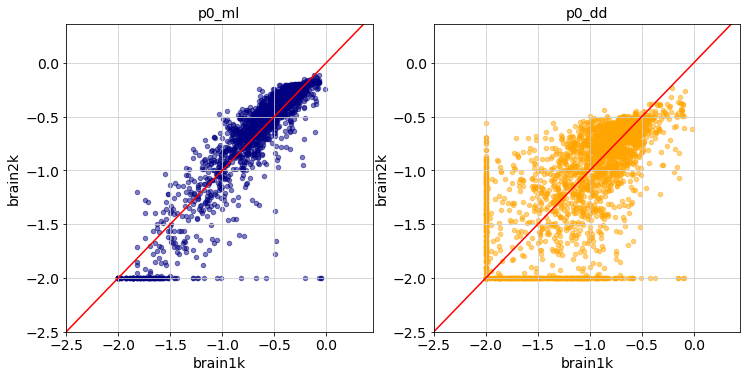

## brain1k vs brain9k
ml: above=1950, below=456, avg_r log10(p0_2/p0_1)=0.066
dd: above=1432, below=975, avg_r log10(p0_2/p0_1)=0.047


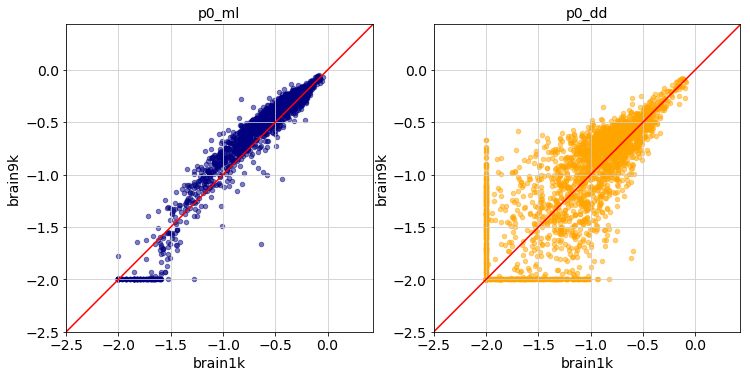

## brain1k vs brain1.3m
ml: above=1695, below=169, avg_r log10(p0_2/p0_1)=0.172
dd: above=1341, below=523, avg_r log10(p0_2/p0_1)=0.183


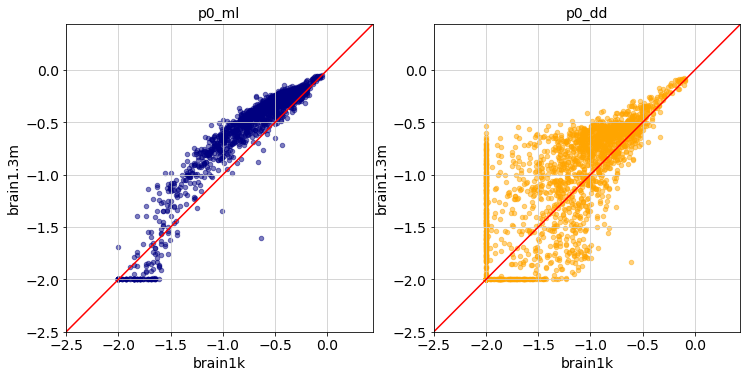

In [5]:
plot_list = [['brain9k','brain1k'],['brain9k','brain2k'],['brain9k','brain1.3m']]
plot_list = [['brain1k','brain2k'],['brain1k','brain9k'],['brain1k','brain1.3m']]
# plot_list = [['brain9k','brain1k']]
for pair in plot_list:    
    d1,d2=pair
    print('## %s vs %s'%(d1,d2))
    sd.fig_xx_zero(p0_dd[d1],p0_ml[d1],p0_dd[d2],p0_ml[d2],gene_list[d1],gene_list[d2],[d1,d2],mean_fil=0.5)    

## probability estimation as a function of the mean_ct

In [49]:
dataname

['brain9k', 'brain1k', 'PBMC8k', 'PBMC68k', 'brain2k', 'brain1.3m']

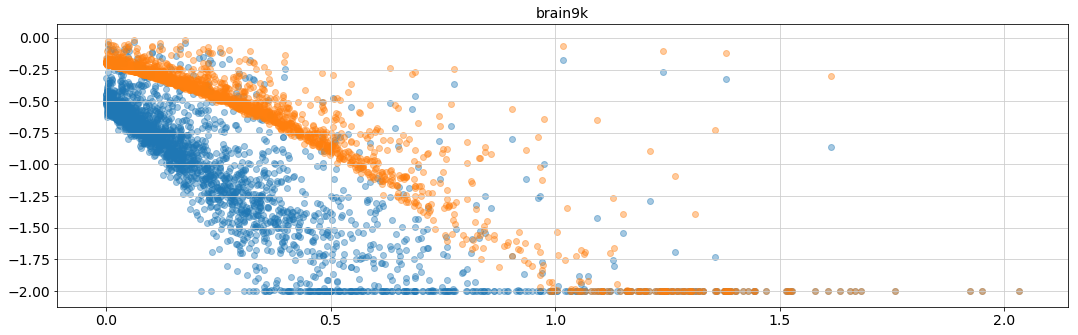

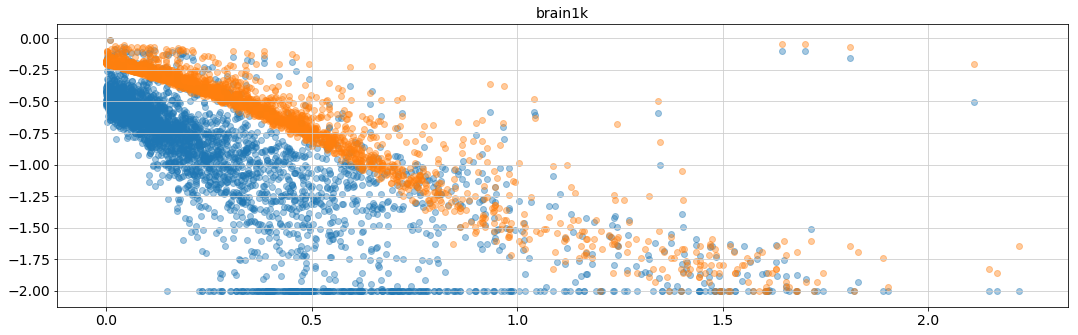

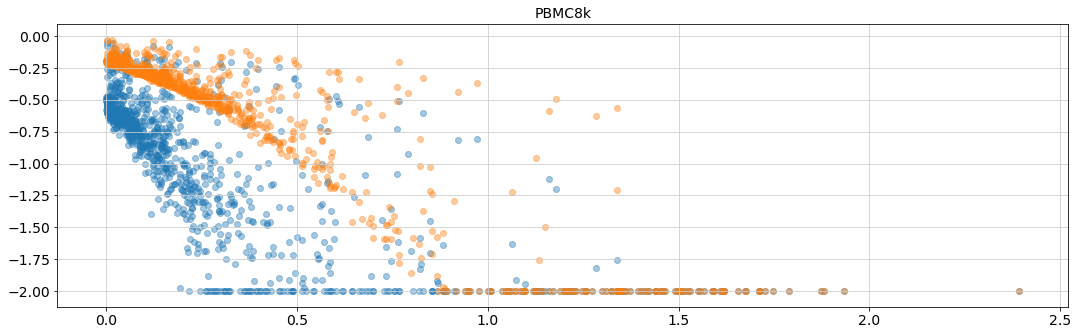

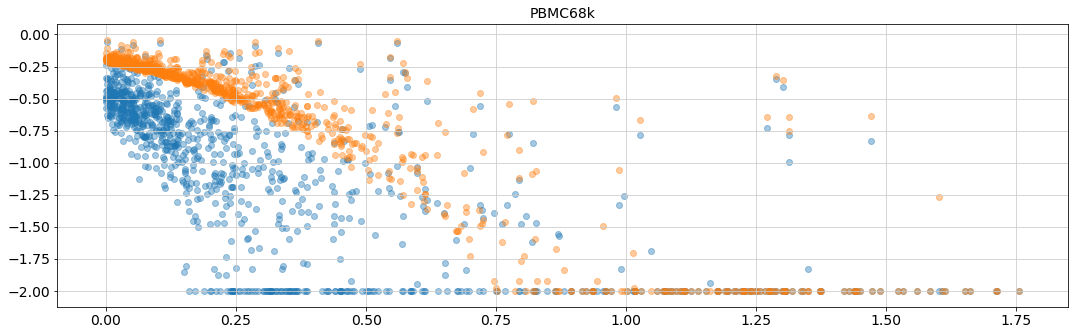

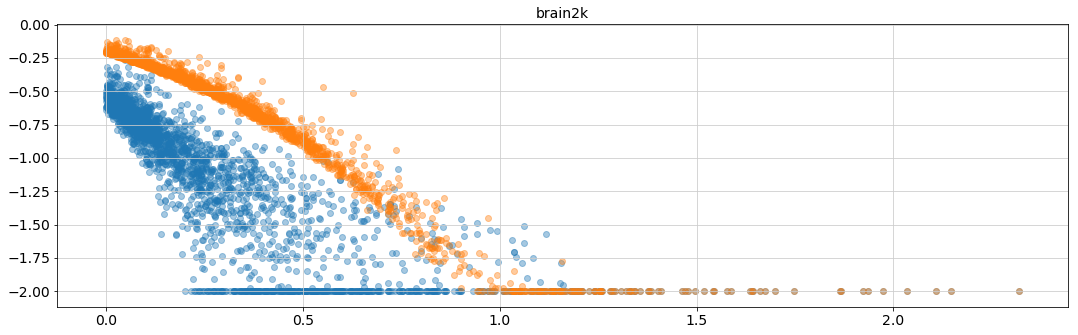

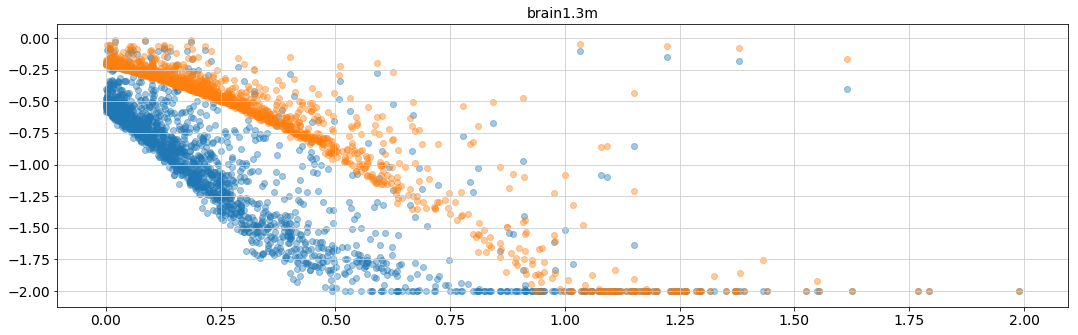

In [56]:
for dname in dataname:   
    plt.figure(figsize=[18,5])
    plt.scatter(np.log10(mean_ct[dname]+0.5),np.log10(p0_dd[dname].clip(min=1e-2)),alpha=0.4,label='dd')
    plt.scatter(np.log10(mean_ct[dname]+0.5),np.log10(p0_ml[dname].clip(min=1e-2)),alpha=0.4,label='ml')
    plt.title(dname)
    plt.show()

# high vs low experiments 

In [6]:
dataset.keys()

dict_keys(['brain9k', 'brain1k', 'PBMC8k', 'PBMC68k', 'brain2k', 'brain1.3m'])

### the sequencing depth seems to be 
1k > 9k > 2k > 1.3m

In [ ]:
## generate a mean sequencing depth plot 
plt.figure(figsize=[18,5])
bins = np.linspace(-1,4,20)
for dname in ['brain1k','brain2k','brain9k','brain1.3m']:
    data = dataset[dname].copy()
    sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
    mean_g = np.array(data.X.mean(axis=0),dtype=float).reshape(-1)
    plt.hist(np.log10(mean_g),alpha=0.3,bins=bins,label=dname)
plt.legend()
plt.show()

In [23]:
mean_ct['brain1k']

array([ 1.6025776,  0.8410331,  0.8055869, ..., 35.15038  ,  0.5606876,
        1.5359828], dtype=float32)

In [40]:
d_deep = 'brain1k'
d_shallow = 'brain1.3m'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (mean_ct[d_shallow][temp_shallow]<5) and (mean_ct[d_deep][temp_deep]>5):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,mean_ct[d_shallow][temp_shallow],
                mean_ct[d_deep][temp_deep]))

gene: COX5B, mean_shallow=2.856, mean_deep=6.385
gene: PANTR1, mean_shallow=4.799, mean_deep=11.683
gene: HSPE1, mean_shallow=2.534, mean_deep=6.185
gene: EEF1B2, mean_shallow=3.679, mean_deep=9.041
gene: NCL, mean_shallow=2.858, mean_deep=5.488
gene: SNRPE, mean_shallow=3.301, mean_deep=8.300
gene: CELF2, mean_shallow=4.514, mean_deep=8.417
gene: ATP5C1, mean_shallow=2.639, mean_deep=5.876
gene: VIM, mean_shallow=2.732, mean_deep=8.107
gene: SET, mean_shallow=3.199, mean_deep=5.414
gene: SWI5, mean_shallow=2.298, mean_deep=5.350
gene: HNRNPA3, mean_shallow=3.471, mean_deep=5.177
gene: MDK, mean_shallow=2.084, mean_deep=5.747
gene: MEIS2, mean_shallow=4.142, mean_deep=7.295
gene: SERF2, mean_shallow=3.819, mean_deep=9.134
gene: SNRPB, mean_shallow=2.039, mean_deep=5.291
gene: CST3, mean_shallow=3.368, mean_deep=5.916
gene: DYNLRB1, mean_shallow=3.215, mean_deep=7.749
gene: RBM39, mean_shallow=3.370, mean_deep=7.865
gene: TOP1, mean_shallow=2.394, mean_deep=5.415
gene: ATP5E, mean_shall

ml: above=166, below=1, avg_r log10(p0_2/p0_1)=0.303
dd: above=75, below=92, avg_r log10(p0_2/p0_1)=-0.136


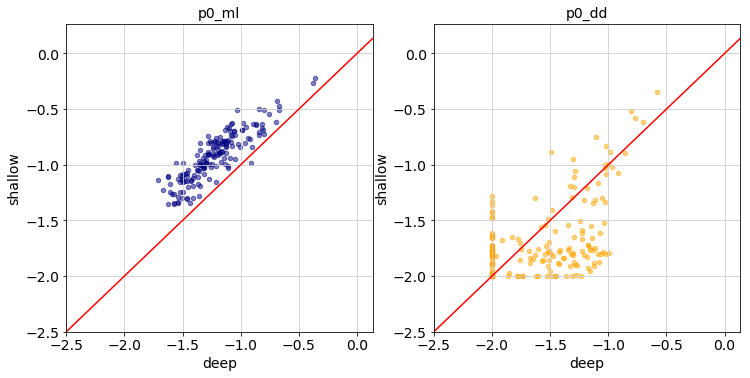

In [41]:
sd.fig_xx_zero(p0_dd[d_deep][idx_deep],p0_ml[d_deep][idx_deep],
               p0_dd[d_shallow][idx_shallow],p0_ml[d_shallow][idx_shallow],
               gene_list_,gene_list_,['deep','shallow'],mean_fil=0.5)    

### try another two...

In [36]:
d_deep = 'brain1k'
d_shallow = 'brain9k'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (mean_ct[d_shallow][temp_shallow]<3) and (mean_ct[d_deep][temp_deep]>5):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,mean_ct[d_shallow][temp_shallow],
                mean_ct[d_deep][temp_deep]))

gene: NCL, mean_shallow=2.953, mean_deep=5.488
gene: MDK, mean_shallow=2.773, mean_deep=5.747
gene: SNRPB, mean_shallow=2.716, mean_deep=5.291
gene: TXN1, mean_shallow=2.830, mean_deep=5.542
gene: AUTS2, mean_shallow=2.107, mean_deep=6.567
gene: PDAP1, mean_shallow=2.992, mean_deep=6.010
gene: MRPS33, mean_shallow=2.609, mean_deep=5.049
gene: LDHB, mean_shallow=2.666, mean_deep=5.236
gene: PAFAH1B3, mean_shallow=2.750, mean_deep=5.076
gene: ABRACL, mean_shallow=2.349, mean_deep=6.098
gene: HNRNPC, mean_shallow=2.955, mean_deep=5.899
gene: FKBP3, mean_shallow=2.887, mean_deep=5.798


ml: above=12, below=0, avg_r log10(p0_2/p0_1)=0.291
dd: above=7, below=5, avg_r log10(p0_2/p0_1)=0.151


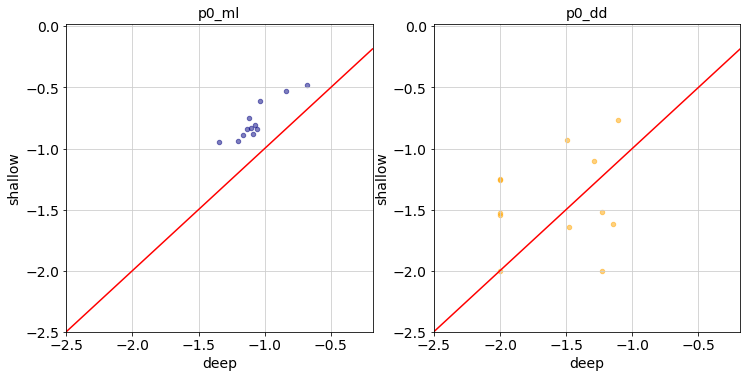

In [37]:
sd.fig_xx_zero(p0_dd[d_deep][idx_deep],p0_ml[d_deep][idx_deep],
               p0_dd[d_shallow][idx_shallow],p0_ml[d_shallow][idx_shallow],
               gene_list_,gene_list_,['deep','shallow'],mean_fil=0.5)    

In [38]:
d_deep = 'brain1k'
d_shallow = 'brain2k'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (mean_ct[d_shallow][temp_shallow]<3) and (mean_ct[d_deep][temp_deep]>5):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,mean_ct[d_shallow][temp_shallow],
                mean_ct[d_deep][temp_deep]))

gene: HSPE1, mean_shallow=2.838, mean_deep=6.185
gene: NCL, mean_shallow=2.905, mean_deep=5.488
gene: VIM, mean_shallow=1.988, mean_deep=8.107
gene: SNRPB, mean_shallow=2.567, mean_deep=5.291
gene: TOP1, mean_shallow=1.849, mean_deep=5.415
gene: XIST, mean_shallow=1.453, mean_deep=10.561
gene: COX7B, mean_shallow=2.369, mean_deep=5.054
gene: WBP5, mean_shallow=2.946, mean_deep=5.243
gene: CLTA, mean_shallow=2.698, mean_deep=5.247
gene: TXN1, mean_shallow=2.168, mean_deep=5.542
gene: AUTS2, mean_shallow=1.243, mean_deep=6.567
gene: PDAP1, mean_shallow=2.900, mean_deep=6.010
gene: ABRACL, mean_shallow=2.367, mean_deep=6.098
gene: MARCKS, mean_shallow=2.540, mean_deep=5.195
gene: SLC25A3, mean_shallow=2.722, mean_deep=5.266
gene: SNRPF, mean_shallow=2.581, mean_deep=6.543
gene: ELAVL3, mean_shallow=2.422, mean_deep=5.140
gene: RPS27L, mean_shallow=2.697, mean_deep=5.291
gene: NSG2, mean_shallow=2.312, mean_deep=6.166
gene: NEUROD2, mean_shallow=2.837, mean_deep=7.447
gene: BZW2, mean_shal

ml: above=22, below=2, avg_r log10(p0_2/p0_1)=0.236
dd: above=8, below=16, avg_r log10(p0_2/p0_1)=-0.249


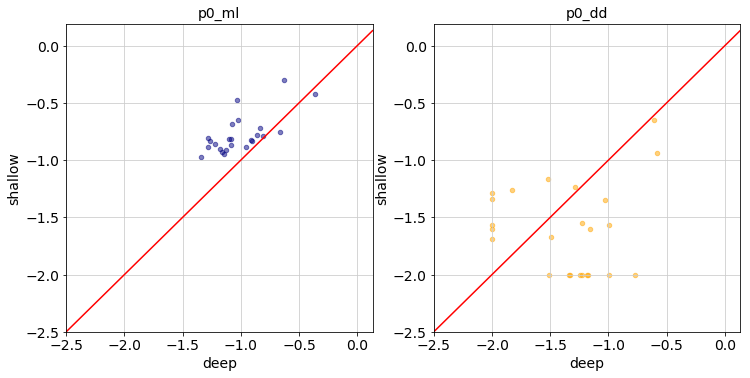

In [39]:
sd.fig_xx_zero(p0_dd[d_deep][idx_deep],p0_ml[d_deep][idx_deep],
               p0_dd[d_shallow][idx_shallow],p0_ml[d_shallow][idx_shallow],
               gene_list_,gene_list_,['deep','shallow'],mean_fil=0.5)    

In [380]:
d_deep = 'PBMC8k'
d_shallow = 'PBMC68k'
gene_list_ = []
idx_deep = []
idx_shallow = []
data_deep = dataset[d_deep].copy()
sc.pp.filter_genes(data_deep,min_counts=2*data_deep.shape[0])

for gene in data_deep.var_names: 
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if M_ml_nsf[d_shallow][temp_shallow,0]<2:
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,M_ml_nsf[d_shallow][temp_shallow,0],
                M[d_deep][temp_deep,0]))

gene: RPL22, mean_shallow=1.345, mean_deep=9.018
gene: CDC42, mean_shallow=0.151, mean_deep=2.247
gene: LAPTM5, mean_shallow=0.617, mean_deep=3.061
gene: YBX1, mean_shallow=1.445, mean_deep=3.569
gene: JUN, mean_shallow=1.243, mean_deep=5.684
gene: TXNIP, mean_shallow=0.890, mean_deep=3.033
gene: CTSS, mean_shallow=0.337, mean_deep=4.464
gene: S100A10, mean_shallow=0.860, mean_deep=2.599
gene: S100A11, mean_shallow=0.402, mean_deep=2.592
gene: S100A9, mean_shallow=0.299, mean_deep=16.659
gene: S100A8, mean_shallow=0.208, mean_deep=13.682
gene: S100A6, mean_shallow=1.513, mean_deep=9.360
gene: FCER1G, mean_shallow=0.435, mean_deep=2.880
gene: PTPRC, mean_shallow=0.403, mean_deep=2.643
gene: H3F3A, mean_shallow=0.131, mean_deep=5.891
gene: OST4, mean_shallow=0.576, mean_deep=2.357
gene: ZFP36L2, mean_shallow=0.610, mean_deep=2.881
gene: CALM2, mean_shallow=0.509, mean_deep=2.672
gene: CXCR4, mean_shallow=0.377, mean_deep=2.074
gene: NBEAL1, mean_shallow=0.375, mean_deep=2.944
gene: ARPC2

ml: above=108, below=3, avg_r log10(cv2/cv1)=0.272
dd: above=87, below=24, avg_r log10(cv2/cv1)=0.169


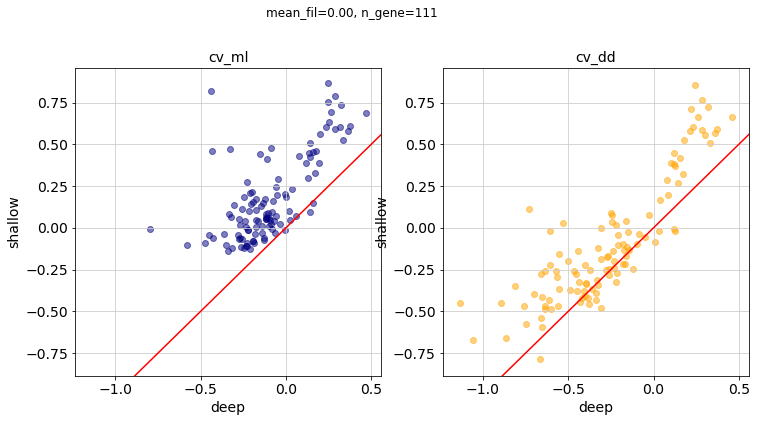

In [381]:
sd.fig_xx_cv(M[d_deep][idx_deep,:],M_ml[d_deep][idx_deep,:],
             M[d_shallow][idx_shallow,:],M_ml[d_shallow][idx_shallow,:],
             gene_list_,gene_list_,['deep','shallow'],mean_fil=0,s=None,margin=0.1)    

# behaviours of low count genes 

In [143]:
X = dataset['brain1k'].copy().X
Nrc = np.array(X.sum(axis=1),dtype=int)
Nr = Nrc.mean()
g_ml = Nrc/Nr
print('ml',(g_ml**2).mean())
print('dd',((Nrc**2).mean()-Nrc.mean())/Nr**2)


ml 1.6218973700339285
dd 1.621810551688494


Nr=7332
gamma_c [0.3020941  0.3020941  0.30361167 3.06614736 5.08897634 7.90790987]


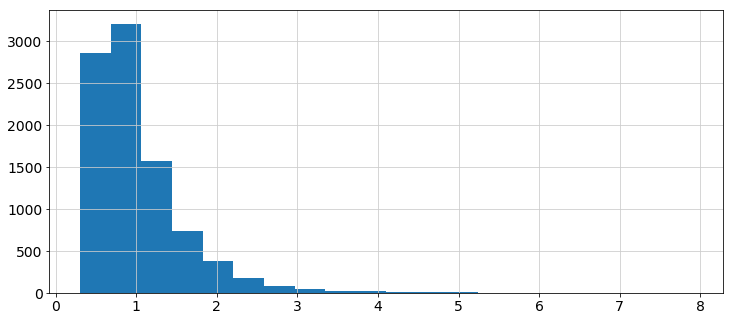

#time start: 0.0s
n_cell=9128, n_gene=1188


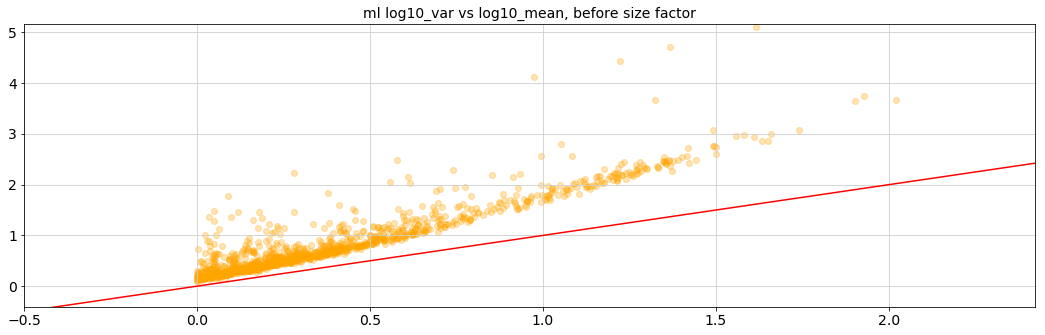

M1, sf=1.0000
M2, sf=1.3507
#time total: 0.6886s



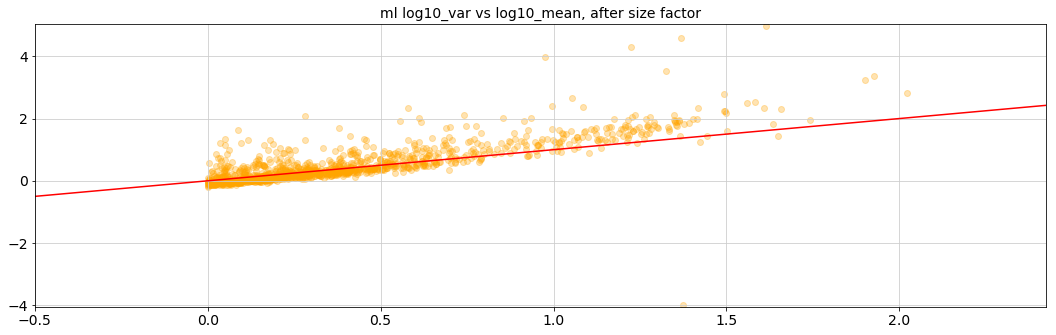

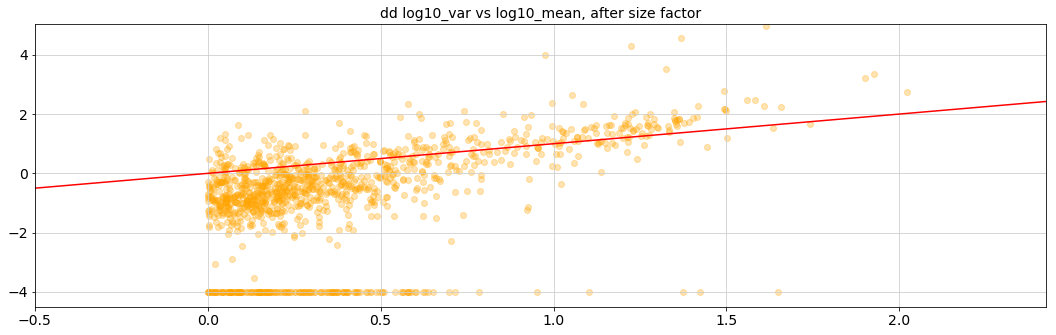

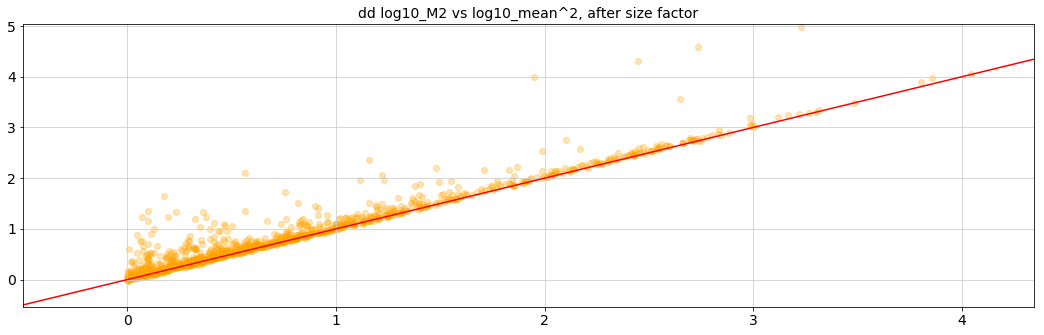

In [232]:
data_9k = dataset['brain9k'].copy()
sf_9k = sd.sf(data_9k,verbose=True)
sc.pp.filter_genes(data_9k,min_counts=1*data_9k.shape[0])
M_9k,M_ml_9k,gene_list_9k = sd.dd_moment_anndata(data_9k,gamma_c=sf_9k,verbose=True)

Nr=7590
gamma_c [0.29522318 0.29562254 0.29734204 2.87913475 5.29541401 5.88101435]


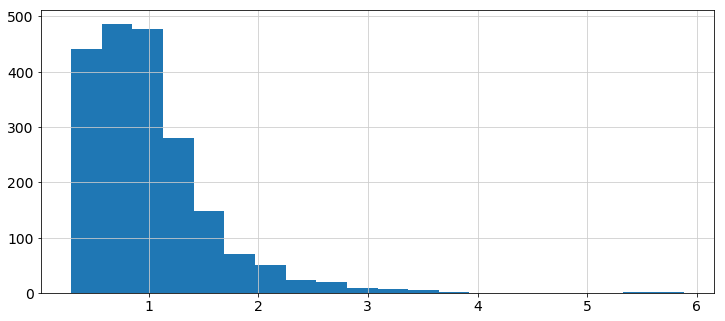

#time start: 0.0s
n_cell=2022, n_gene=1207


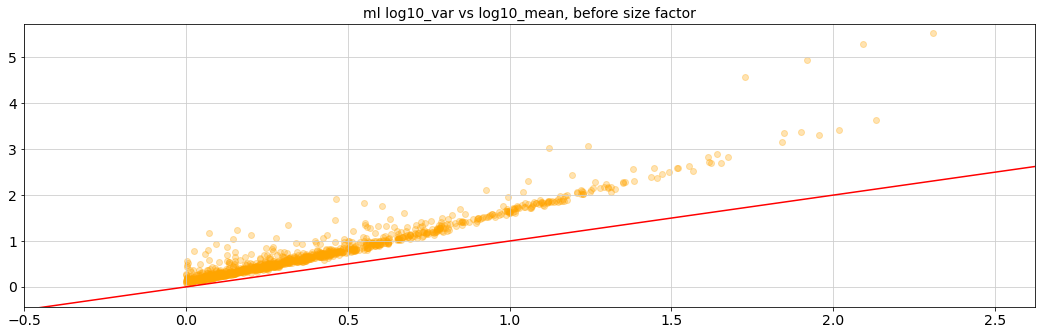

M1, sf=1.0000
M2, sf=1.3109
#time total: 0.3809s



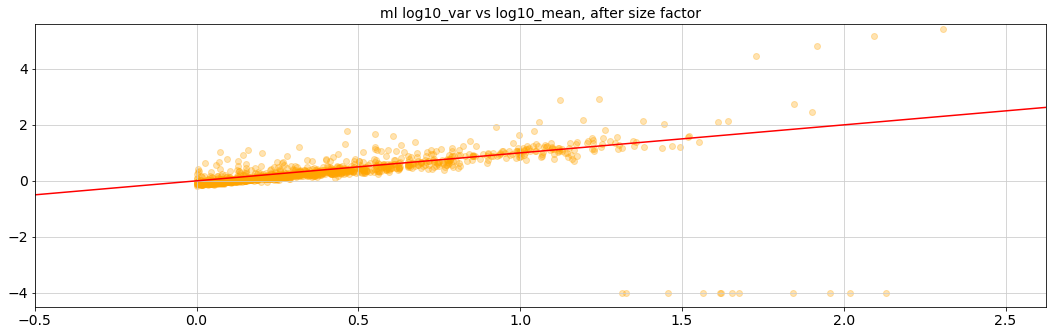

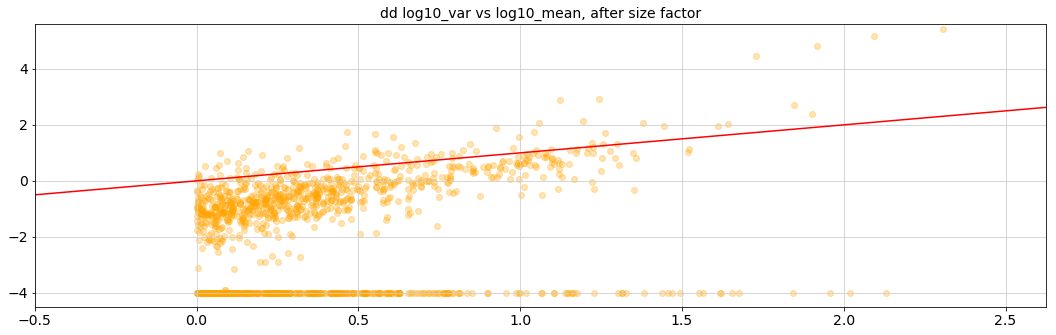

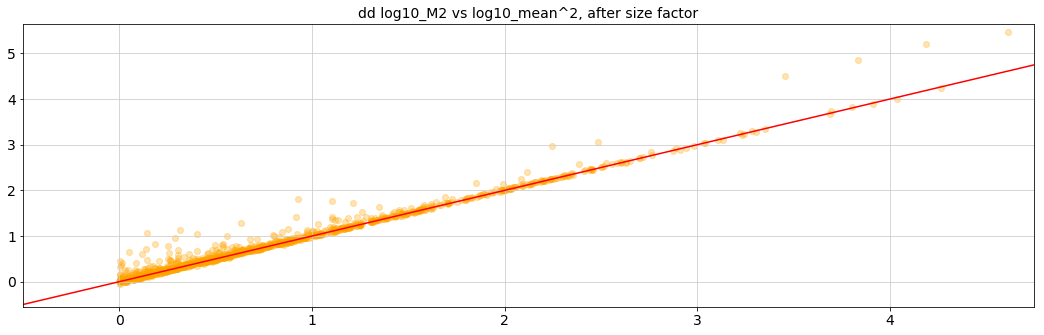

In [244]:
data_2k = dataset['brain2k'].copy()
sf_2k = sd.sf(data_2k,verbose=True)
sc.pp.filter_genes(data_2k,min_counts=1*data_2k.shape[0])
M_2k,M_ml_2k,gene_list_2k = sd.dd_moment_anndata(data_2k,gamma_c=sf_2k,verbose=True)

Nr=11518
gamma_c [0.34015429 0.34018659 0.34047724 4.38291998 6.16407987 7.50292826]


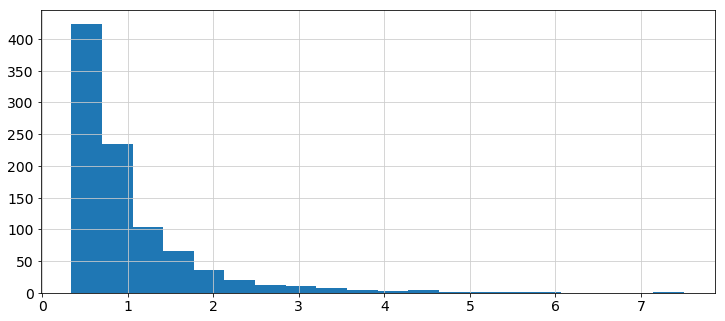

#time start: 0.0s
n_cell=931, n_gene=1770


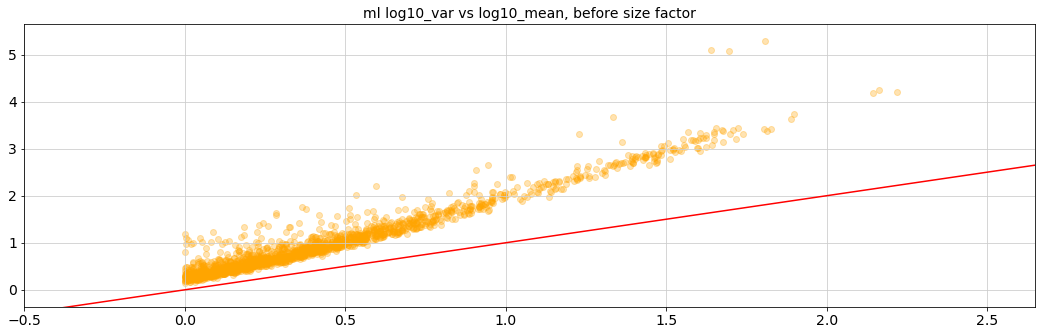

M1, sf=1.0000
M2, sf=1.6219
#time total: 0.3454s



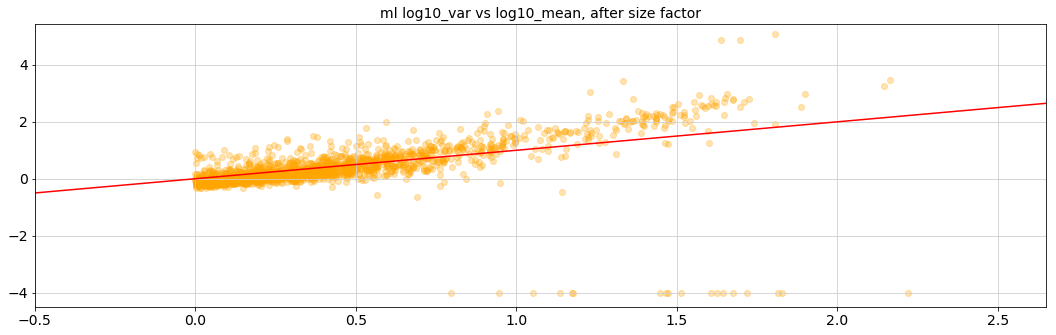

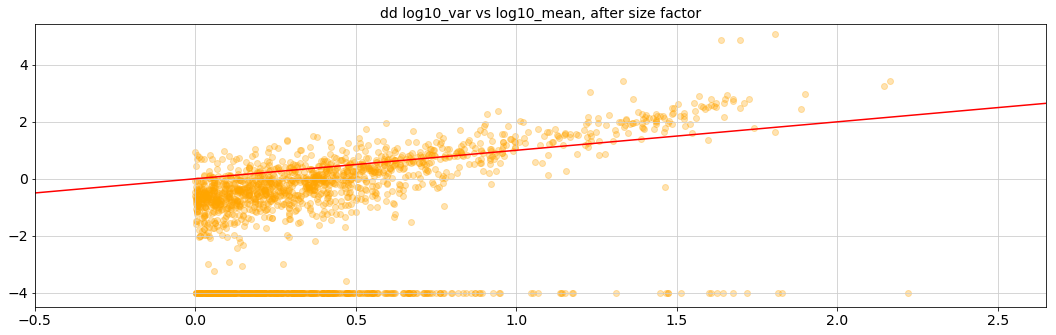

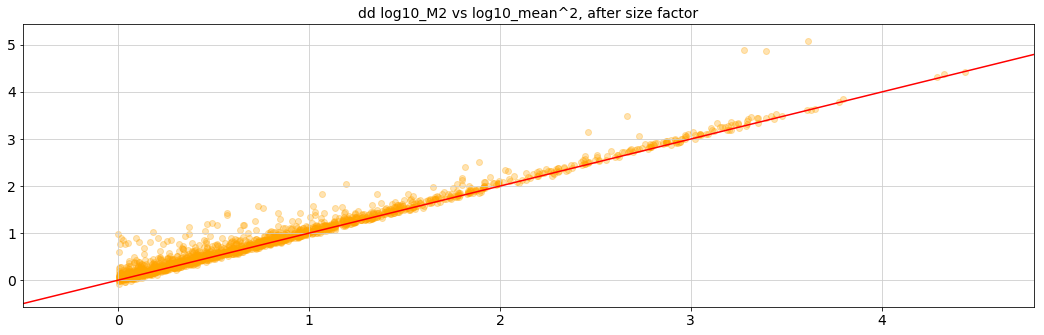

In [233]:
data_1k = dataset['brain1k'].copy()
sf_1k = sd.sf(data_1k,verbose=True)
sc.pp.filter_genes(data_1k,min_counts=1*data_1k.shape[0])
M_1k,M_ml_1k,gene_list_1k = sd.dd_moment_anndata(data_1k,gamma_c=sf_1k,verbose=True)

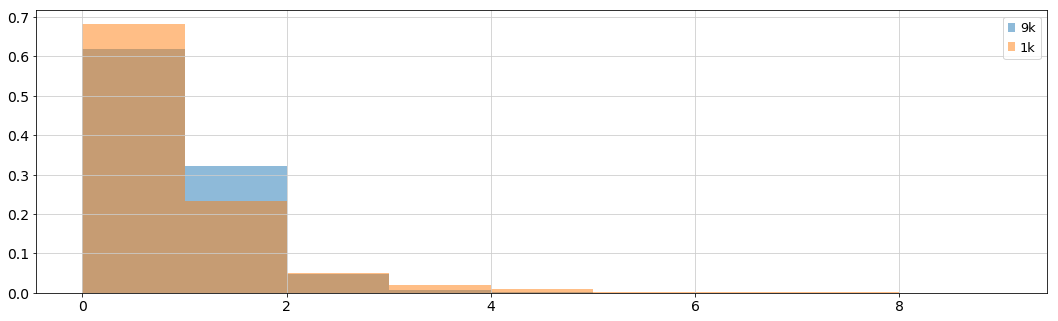

In [234]:
plt.figure(figsize=[18,5])
bins=np.arange(10)
plt.hist(sf_9k,weights=1/sf_9k.shape[0]*np.ones([sf_9k.shape[0]]),alpha=0.5,bins=bins,label='9k')
plt.hist(sf_1k,weights=1/sf_1k.shape[0]*np.ones([sf_1k.shape[0]]),alpha=0.5,bins=bins,label='1k')
plt.legend()
plt.show()

In [89]:
M1,M2 = M_9k[:,0],M_9k[:,1]
idx_M20 = np.where(M2==0)[0]
gene_M20 = list(data_9k.var_names[idx_M20])
cts_Farp2 = np.array((data_9k[:,'Farp2'].X),dtype=int)

In [98]:
cts_Farp2_ = np.array((data_1k[:,'Farp2'].X),dtype=int)

ml: above=173, below=1000, avg_r log10(cv2/cv1)=-0.127
dd: above=460, below=632, avg_r log10(cv2/cv1)=-0.111


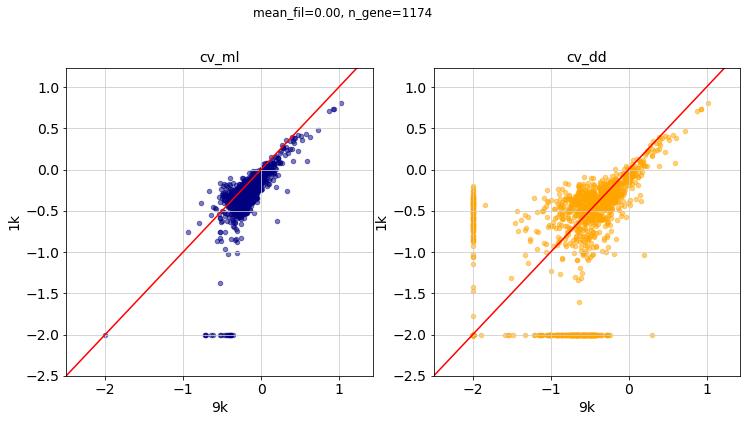

In [238]:
sd.fig_xx_cv(M_9k,M_ml_9k,M_1k,M_ml_1k,gene_list_9k,gene_list_1k,['9k','1k'],mean_fil=0)    

In [ ]:
M,M_ml,M_nsf,M_ml_nsf,gene_list,gene_list_nsf = {},{},{},{},{},{}

for dname in dataset.keys():
    if dname=='brain1.3m': break
    print('## processing %s ...'%dname)
    print('# n_cell=%d, n_gene=%d'%(dataset[dname].shape[0],dataset[dname].shape[1]))
    temp = dataset[dname].copy()
    sc.pp.filter_cells(temp, min_counts=0.01*temp.shape[1])
    gamma_c = sd.sf(temp,verbose=False)
    sc.pp.filter_genes(temp,min_counts=0.01*temp.shape[0])
    print('# after filtering: n_cell=%d, n_gene=%d'%(temp.shape[0],temp.shape[1]))
    M_,M_ml_,gene_list_ = sd.dd_moment_anndata(temp,gamma_c=gamma_c,verbose=False)
    M_nsf_,M_ml_nsf_,gene_list_nsf_ = sd.dd_moment_anndata(temp,gamma_c=None,verbose=False)
    
    M[dname],M_ml[dname],M_nsf[dname],M_ml_nsf[dname],gene_list[dname],gene_list_nsf[dname] = \
    M_,M_ml_,M_nsf_,M_ml_nsf_,gene_list_,gene_list_nsf_
    print('\n')
#     if dname=='PBMC8k': break

# subsample experiment

In [45]:
## subsampling experiment 
d1 = dataset['brain9k']
sc.pp.filter_cells(d1,min_counts=0.01*d1.shape[1])
sf1 = sd.sf(d1,verbose=False)
sc.pp.filter_genes(d1,min_counts=0.01*d1.shape[0])

d2 = dataset['brain1k']
sc.pp.filter_cells(d2,min_counts=0.01*d2.shape[1])
sf2 = sd.sf(d2,verbose=False)
sc.pp.filter_genes(d2,min_counts=0.01*d2.shape[0])

In [50]:
d2.n_vars

12343

In [48]:
d2.obs

,n_counts
AAACCTGGTCTCGTTC-1,9419.0
AAACGGGAGCCACGTC-1,5717.0
AAACGGGAGCGAGAAA-1,5189.0
AAACGGGCACACCGAC-1,13760.0
AAACGGGTCGCCAGCA-1,15808.0
AAACGGGTCGCGTTTC-1,7927.0
AAACGGGTCGGCGGTT-1,12496.0
AAAGATGAGGCTCAGA-1,10766.0
AAAGTAGGTACAGACG-1,6417.0
AAAGTAGGTTGGACCC-1,7341.0


Nr=11531
gamma_c [0.33993718 0.33996944 0.3402598  4.38292661 6.16535087 7.50411367]


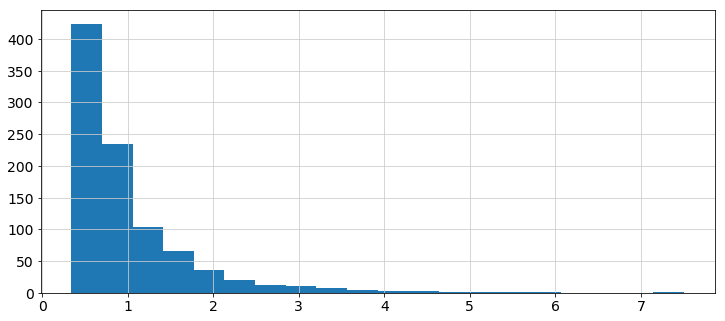

array([[0.81680316],
       [0.49577063],
       [0.44998318],
       [1.19324887],
       [1.37084877],
       [0.68741888],
       [1.08363652],
       [0.93361324],
       [0.55647373],
       [0.63660175],
       [0.40575665],
       [2.19493628],
       [0.56887448],
       [0.83536094],
       [0.49620423],
       [0.63434708],
       [0.4185043 ],
       [0.62151271],
       [0.38329652],
       [0.35571998],
       [0.39023402],
       [0.46090972],
       [3.03012371],
       [0.69609076],
       [1.14798176],
       [2.23604083],
       [0.6863783 ],
       [0.58535105],
       [0.57234323],
       [1.01608264],
       [2.57129526],
       [0.39214182],
       [0.51025265],
       [0.76685321],
       [0.85495937],
       [0.75835478],
       [0.57711273],
       [0.41035277],
       [0.96197021],
       [2.28971982],
       [0.94800854],
       [0.96205693],
       [0.77205634],
       [0.56341124],
       [0.35832155],
       [1.85309124],
       [1.45921504],
       [0.378

In [43]:
sd.sf(d2)

Nr=7346
gamma_c [0.30261216 0.30261216 0.3033101  3.06700076 5.10077825 7.93788576]


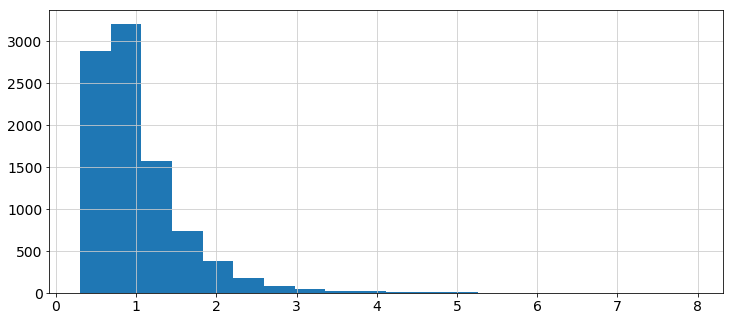

array([[0.43166134],
       [1.21643829],
       [0.38837269],
       ...,
       [2.54014516],
       [0.51674122],
       [1.16961026]])

In [42]:
sd.sf(d1)

In [40]:
d2.X.sum()

10735866.0

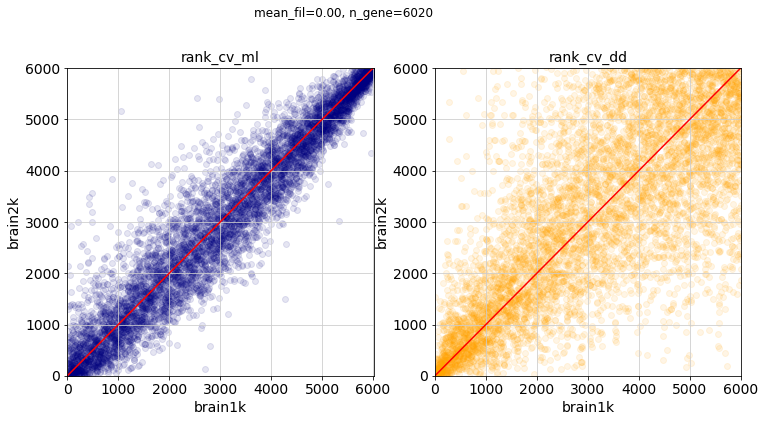

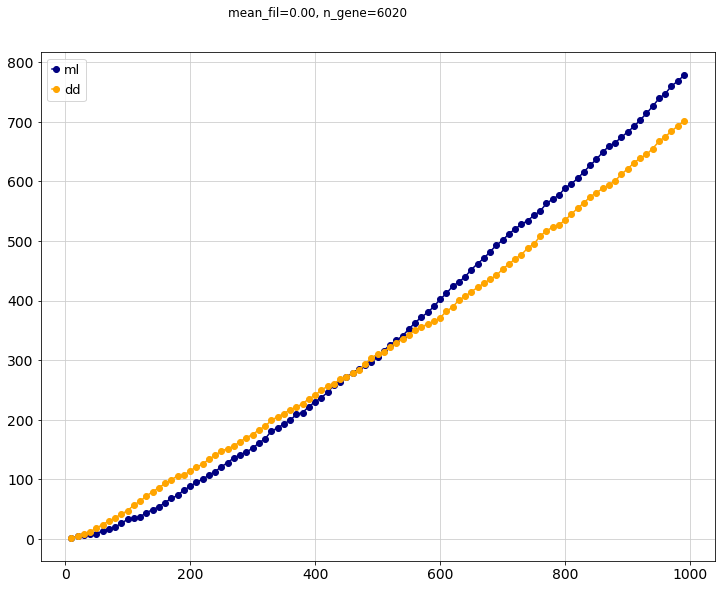

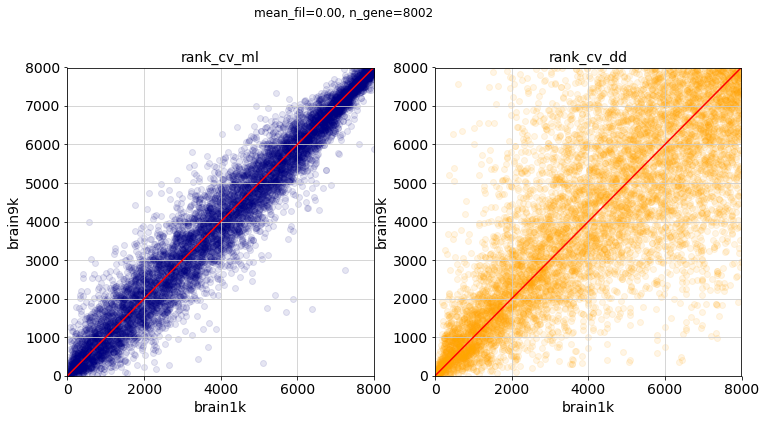

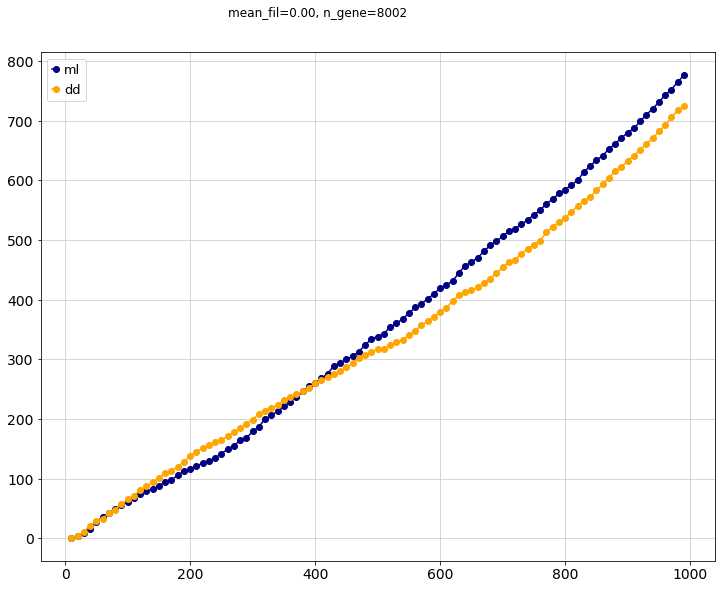

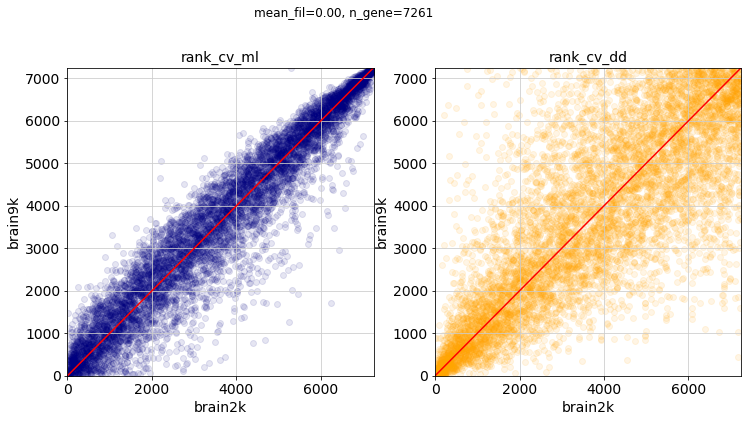

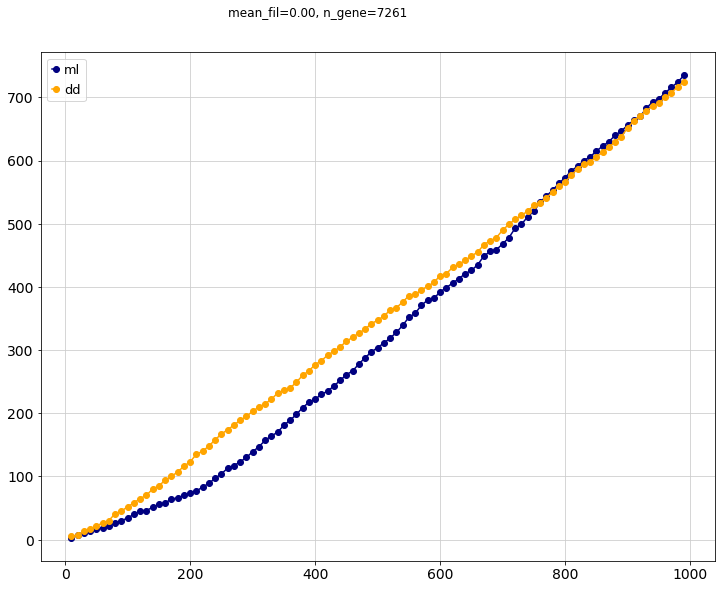

In [23]:
# plot_list = [['brain1k','brain2k'],['brain1k','brain9k'],['brain2k','brain9k']]
for pair in plot_list:
    d1,d2=pair
    sd.fig_xx_rank(M[d1],M_ml[d1],M[d2],M_ml[d2],gene_list[d1],gene_list[d2],[d1,d2],mean_fil=0)

In [ ]:
## MSE



